In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# From the expected conversion rate and stdev of it, get the
# realized conversion rate
def get_conversion_rate(expected, stdev):
    conversion_rate = max(expected + np.random.normal()*stdev, 
                          0.000001)
    return conversion_rate

# Function for calculating the results of a marketing campaign
def run_campaign(spend, cpm, conversion_rate):
    return np.random.binomial(spend/cpm*1000, conversion_rate)


# Gather marketing campaign inputs

# Budget
spend = 50000.
# Cost per thousand
cpm = 2
# Conversion rate
conversion_rate_expected = 0.00005
conversion_rate_stdev = 0.00002

# Run the function
conversion_rate = get_conversion_rate(conversion_rate_expected, 
                                      conversion_rate_stdev)
cohort_size = run_campaign(spend, cpm, conversion_rate)
CAC = spend/cohort_size

print('Customers Gained: ', cohort_size)
print('CAC: ', int(CAC))

Customers Gained:  1309
CAC:  38


In [3]:
# Function that models the progression of a cohort over time
def simulate_cohort(cohort_size, churn_rate, transactions, price, 
                    retention_cost, yrs=5):
    customers_left = []
    spending = []
    profit = []
    for i in range(yrs):
        for customer in range(cohort_size):
            # Assume cancels happen at the start of the year 
            # (for simplicity)
            churn_random_num = np.random.random()
            # Generate a random number between 0 and 1, if less 
            # than churn_rate then customer has churned and we 
            # subtract 1 from cohort_size
            if churn_random_num <= churn_rate:
                cohort_size += -1
            # Calculate and record cohort's data
        customers_left.append(cohort_size)
        spending.append(cohort_size*transactions*price)
        profit.append(cohort_size*(transactions*price -\
                                   retention_cost))
    return customers_left, spending, profit


# Gather cohort related inputs

churn_rate = 0.20
# Number of annual transactions per average cohort member
transactions = 6
# Price of goods sold per average transaction
price = 10
# Annual cost of retaining/servicing customer
retention_cost = 20

# Run the function
customers_left, spending, profit =\
    simulate_cohort(cohort_size, churn_rate, transactions, 
                    price, retention_cost, yrs=5)

In [4]:
# Function to calculate the present value of a set of cashflows
def present_value(cashflows, rate):
    pvs = []
    for i, val in enumerate(cashflows):
        pvs.append(val/(1 + rate)**(i+1))
    return pvs


# Calculate CLTV
rate = 0.10

# Get the PV of the profits
pvs = present_value(profit, rate)
# Value of the cohort in today's dollars is sum of PVs
cohort_value = sum(pvs)

print('Total Cohort Value: ', int(cohort_value))
print('CLTV: ', int(cohort_value/cohort_size))
print('CLTV-CAC Spread: ', int(cohort_value/cohort_size - CAC))

Total Cohort Value:  113285
CLTV:  86
CLTV-CAC Spread:  48


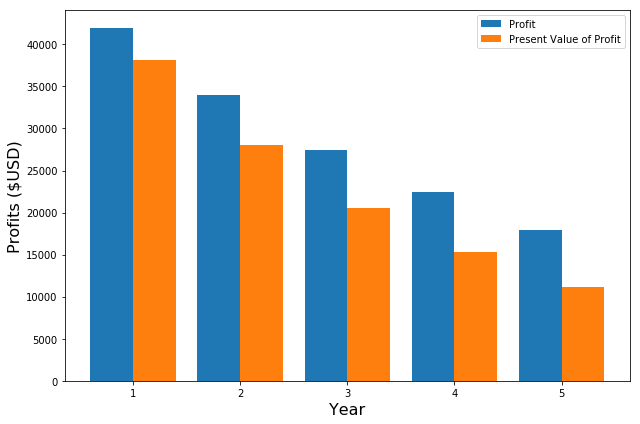

In [5]:
# Bar chart for profit and its PV
fig, ax = plt.subplots(figsize=(9,6))
plt.bar(x=[i-0.2 for i in range(1,6)], height=profit, width=0.4, label='Profit')
plt.bar(x=[i+0.2 for i in range(1,6)], height=pvs, width=0.4, label='Present Value of Profit')

ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Profits ($USD)",fontsize=16)
plt.legend()
plt.tight_layout()

plt.savefig(fname='profit_bar', dpi=150)
plt.show()

In [6]:
# Simulate 1000 times and look at the distributions

cohort_size_list = []
CAC_list = []
CLTV_list = []

for i in range(1000):
    
    # Run marketing campaign sim
    conversion_rate = get_conversion_rate(conversion_rate_expected, 
                                      conversion_rate_stdev)
    cohort_size = run_campaign(spend, cpm, conversion_rate)
    CAC = spend/cohort_size
    
    # Simulate the resulting cohort
    customers_left, spending, profit =\
        simulate_cohort(cohort_size, churn_rate, transactions, 
                        price, retention_cost, yrs=5)
    
    cohort_value = sum(present_value(profit, rate))
    
    cohort_size_list.append(cohort_size)
    CAC_list.append(CAC)
    CLTV_list.append(cohort_value/cohort_size)
    
# Store simulation results in a dataframe
results_df = pd.DataFrame()
results_df['initial_cohort_size'] = cohort_size_list
results_df['CLTV'] = CLTV_list
results_df['CAC'] = CAC_list
results_df['Spread'] = results_df['CLTV'] - results_df['CAC']

plot_df = results_df[results_df['CAC']<=1000]

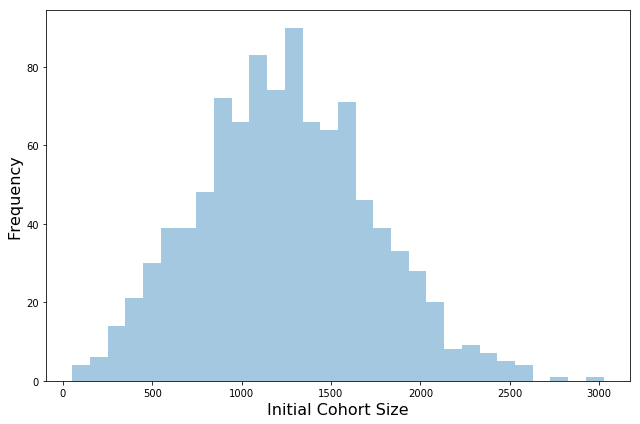

In [7]:
# Histogram for distribution of initial cohort size
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(plot_df['initial_cohort_size'], kde=False, bins=30)

ax.set_xlabel("Initial Cohort Size",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.tight_layout()

plt.savefig(fname='cohort_hist', dpi=150)
plt.show()

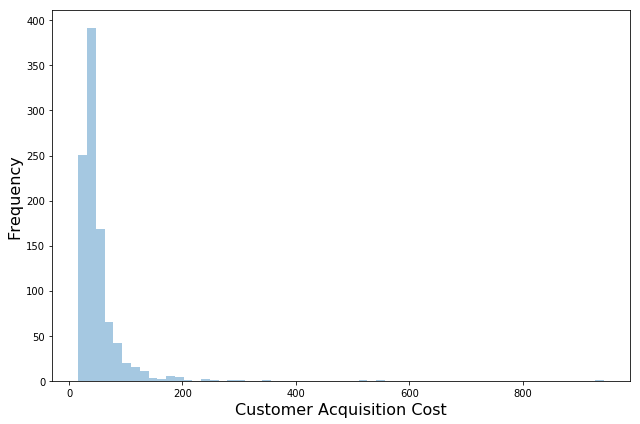

In [25]:
# Histogram for distribution of initial cohort size
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(plot_df['CAC'], kde=False, bins=60)

ax.set_xlabel("Customer Acquisition Cost",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.tight_layout()

plt.savefig(fname='CAC_hist', dpi=150)
plt.show()

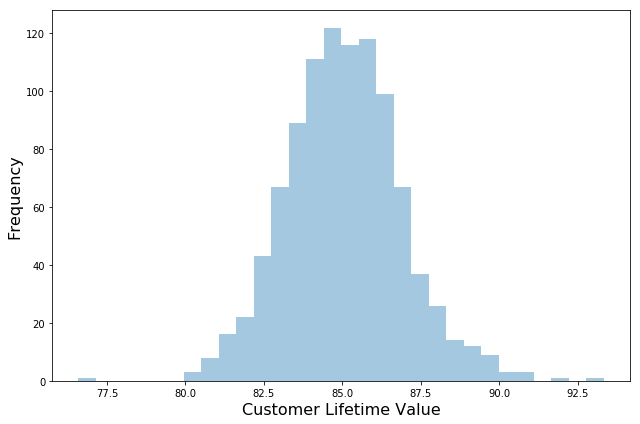

In [9]:
# Histogram for distribution of initial cohort size
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(plot_df['CLTV'], kde=False, bins=30)

ax.set_xlabel("Customer Lifetime Value",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.tight_layout()

plt.savefig(fname='CLTV_hist', dpi=150)
plt.show()

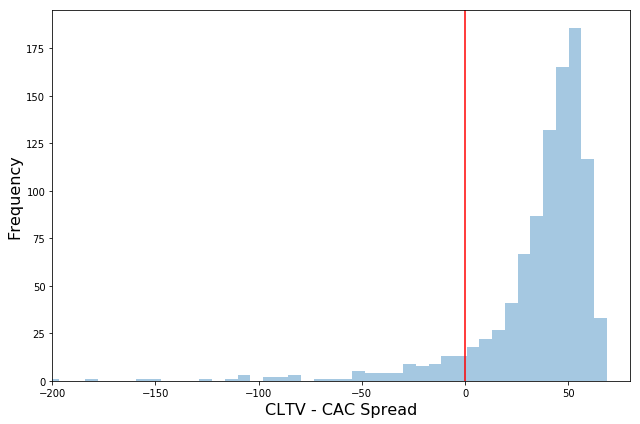

In [40]:
# Histogram for distribution of CLTV-CAC Spread
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(plot_df['Spread'], kde=False, bins=150)
plt.axvline(x=0, color='red')
plt.xlim(-200, 80)

ax.set_xlabel("CLTV - CAC Spread",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.tight_layout()

plt.savefig(fname='spread_hist', dpi=150)
plt.show()

In [19]:
plot_df['CAC'].median()

40.436723150539066

In [20]:
sum(plot_df['Spread'] > plot_df['CAC'].median())/plot_df.shape[0]

0.5860323886639676

In [21]:
conversion_rate_expected*20000

1.0

In [36]:
np.quantile(plot_df['CAC'], 0.94)

102.86135072585732

In [41]:
min(plot_df['CAC'])

16.52892561983471